# Analysis of FAIR metrics

In this notebook, the retrieved results of the FAIR metrics collection is analyzed.

In [1]:
from datetime import date
import statistics
from collections import Counter
from pathlib import Path
import os

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from pandas.plotting import table 
import matplotlib.pyplot as plt
import matplotlib.table as table
import seaborn as sns
from scipy import stats

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 22})

Folders and constants

In [3]:
# subset variable is used to run the notebook for all users, only individual 
# accounts or organisations (group)
subset = "all"  # "user", "group", "all"

# todo make this into something nice
how_fair_is = pd.read_csv("results/repositories_howfairis.csv")
languages = pd.read_csv("results/languages.csv")
contributors = pd.read_csv("results/contributors.csv")
topics = pd.read_csv("results/topics.csv")
installations = pd.read_csv("results/download_stats.csv")


# file paths
fp_repos = Path("..", "collect_repositories", "results", "repositories_filtered.csv")
fp_figs = Path("figs")

# create output folder if not exists
fp_figs.mkdir(exist_ok=True)

FileNotFoundError: [Errno 2] No such file or directory: 'results/languages.csv'

In [ ]:
subset

## Load filtered repositories
Load (manually) filtered repositories into notebook.

In [ ]:
repos = pd.read_csv(fp_repos)

## Filtering for research groups or private users only

In [ ]:
users = pd.read_excel("../collect_users/results/users_enriched.xlsx")

In [ ]:
def add_research_group_filter(dataset):
    user_is_research_group = []
    for row in dataset.iterrows():
        try:
            owner = row[1]['owner']
        except:
            owner = row[1]['html_url_repository'].split('/')[-2]
            
            
      
        row_users = users.loc[users['user_id'] == owner]
        if len(row_users['is_research_group']) == 0:
            user_is_research_group.append(False)
        for i in row_users['is_research_group']:
            if i == 1:
                user_is_research_group.append(True)
                break
            else:
                user_is_research_group.append(False)
                break
                    
    return user_is_research_group
    

In [ ]:
repos['is_research_group'] = add_research_group_filter(repos)
contributors['is_research_group'] = add_research_group_filter(contributors)
topics['is_research_group'] = add_research_group_filter(topics)
languages['is_research_group'] = add_research_group_filter(languages)
how_fair_is['is_research_group'] = add_research_group_filter(how_fair_is)

## Subset repositories
Make a subset of repositories on "user", "group", or "all".

- "user" - Account of individual researcher
- "group" - Account of research group
- "all" - Both individual researcher or research group

In [ ]:
if subset == "user":
    repos = repos[~repos['is_research_group']]
    contributors = contributors[~contributors['is_research_group']]
    topics = topics[~topics['is_research_group']]
    languages = languages[~languages['is_research_group']]
    how_fair_is = how_fair_is[~how_fair_is['is_research_group']]
elif subset == "group":
    repos = repos[repos['is_research_group']]
    contributors = contributors[contributors['is_research_group']]
    topics = topics[topics['is_research_group']]
    languages = languages[languages['is_research_group']]
    how_fair_is = how_fair_is[how_fair_is['is_research_group']]

## Datasets

Using the github API and the Howfairis software, we collected data on the repositories, their FAIRness, the languages used in the repository, the amount of contributors for each repository and the topics mentoined in each repository. 

The Howfairis software gives  boolean value on five measures of FAIRness for each repository. These five measures consist of having a repository (which is always True for our dataset), having a license, being available in a registry, allowing citation of the software and following the FAIR software quality checklist. Below, the first five rows of the datasets are displayed. 

In [ ]:
repos

In [4]:
how_fair_is

id                           node_id                      name  \
0     401148255  MDEwOlJlcG9zaXRvcnk0MDExNDgyNTU=                   CIObund   
1     670803112                      R_kgDOJ_ukqA           genAI-telephone   
2     129522481  MDEwOlJlcG9zaXRvcnkxMjk1MjI0ODE=                      gntm   
3     167386672  MDEwOlJlcG9zaXRvcnkxNjczODY2NzI=                  gntm2019   
4     420233451                      R_kgDOGQxA6w     publicAmenitiesBerlin   
...         ...                               ...                       ...   
1955  335660934  MDEwOlJlcG9zaXRvcnkzMzU2NjA5MzQ=  e-lexicography-2021-WiSe   
1956  601543443                      R_kgDOI9rTEw    elexicography-WiSe2023   
1957  491164984                      R_kgDOHUaVOA             eval-de-lemma   
1958  164424340  MDEwOlJlcG9zaXRvcnkxNjQ0MjQzNDA=                  ttml2tei   
1959  551544549                      R_kgDOIN_m5Q                 wikimedia   

                                           full_name  private  \
0                                     030jmk/CIObund    False   
1                             030jmk/genAI-telephone    False   
2                                        030jmk/gntm    False   
3                                    030jmk/gntm2019    False   
4                       030jmk/publicAmenitiesBerlin    False   
...                                              ...      ...   
1955  zentrum-lexikographie/e-lexicography-2021-WiSe    False   
1956    zentrum-lexikographie/elexicography-WiSe2023    False   
1957             zentrum-lexikographie/eval-de-lemma    False   
1958                  zentrum-lexikographie/ttml2tei    False   
1959                 zentrum-lexikographie/wikimedia    False   

                      owner  \
0                    030jmk   
1                    030jmk   
2                    030jmk   
3                    030jmk   
4                    030jmk   
...                     ...   
1955  zentrum-lexikographie   
1956  zentrum-lexikographie   
1957  zentrum-lexikographie   
1958  zentrum-lexikographie   
1959  zentrum-lexikographie   

                                               html_url  \
0                     https://github.com/030jmk/CIObund   
1             https://github.com/030jmk/genAI-telephone   
2                        https://github.com/030jmk/gntm   
3                    https://github.com/030jmk/gntm2019   
4       https://github.com/030jmk/publicAmenitiesBerlin   
...                                                 ...   
1955  https://github.com/zentrum-lexikographie/e-lex...   
1956  https://github.com/zentrum-lexikographie/elexi...   
1957  https://github.com/zentrum-lexikographie/eval-...   
1958  https://github.com/zentrum-lexikographie/ttml2tei   
1959  https://github.com/zentrum-lexikographie/wikim...   

                                            description   fork  \
0                                               AR Bund  False   
1     A retrofitted rotary dial phone with speech-to...  False   
2     scraped Instagram follower count for GNTM cont...  False   
3                                             gntm 2019  False   
4     Telegram Bot to find the closest public amenit...  False   
...                                                 ...    ...   
1955                             Wintersemester 2020/21  False   
1956  Course materials for the compact course in dig...  False   
1957                                                NaN  False   
1958                     Convert ttml to tei xml format  False   
1959  Data Exchange Routines between the ZDL and Wik...  False   

                                                    url  ... open_issues  \
0           https://api.github.com/repos/030jmk/CIObund  ...           0   
1     https://api.github.com/repos/030jmk/genAI-tele...  ...           0   
2              https://api.github.com/repos/030jmk/gntm  ...           0   
3          https://api.github.com/repos/030jmk/gntm2019  ...           0   
4     https://api.github.com

In [5]:
languages

NameError: name 'languages' is not defined

In [6]:
contributors

NameError: name 'contributors' is not defined

In [7]:
topics

NameError: name 'topics' is not defined

In [8]:
print("The repository data from Github contains the following columns:")
print(repos.columns)

The repository data from Github contains the following columns:


NameError: name 'repos' is not defined

## Sofware licenses 

A license is important because it shows that people have permission to use and modify your code. The plots below show the licenses used in the collection. 


In [9]:
# short names for licenses
licenses_abbr = {
    'MIT License': 'MIT',
    'GNU General Public License v3.0': 'GPLv3',
    'Other': 'Other',
    'Apache License 2.0': 'Apache 2.0',
    'GNU General Public License v2.0': 'GPLv2',
    'BSD 3-Clause "New" or "Revised" License': 'BSD 3-Clause',
    'Creative Commons Attribution 4.0 International': 'CC-BY',
    'Creative Commons Zero v1.0 Universal': 'CC0',
    'GNU Lesser General Public License v3.0': 'LGPLv3',
    'The Unlicense': 'Unlicense',
    'GNU Affero General Public License v3.0': 'AGPPLv3',
    'BSD 2-Clause "Simplified" License': 'BSD 2-Clause',
    'Mozilla Public License 2.0': 'MPL 2.0',
    'GNU Lesser General Public License v2.1': 'LGPLv2.1',
    'Creative Commons Attribution Share Alike 4.0 International': 'CC-BY-SA',
    'ISC License': 'ISC'
    
}

In [10]:
# # all licences
# repos["license"].value_counts().plot(kind='bar', title = 'All licences')
# plt.savefig(Path(fp_figs, f'licenses_all_{subset}.png'), bbox_inches="tight")


In [11]:
# top most used 10 licences
top_10_licenses = repos["license"].value_counts().head(10)
print(top_10_licenses)

NameError: name 'repos' is not defined

In [12]:
ax = sns.barplot(top_10_licenses.index, top_10_licenses)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_ylabel("Count")
ax.set_title("Top 10 most popular licenses")

plt.savefig(Path(fp_figs, f'licenses_first10_{subset}.png'), bbox_inches="tight")

NameError: name 'top_10_licenses' is not defined

In [13]:
top_10_licenses_short = repos["license"].replace(licenses_abbr).value_counts().head(10)
print(top_10_licenses_short)

# first 10 licences with short names
ax = sns.barplot(top_10_licenses_short.index, top_10_licenses_short)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_ylabel("Count")
ax.set_title("Top 10 most popular licenses")

plt.savefig(Path(fp_figs, f'licenses_short_first10_{subset}.png'), bbox_inches="tight")

NameError: name 'repos' is not defined

In [14]:
# first 10 licences with short names
ax = sns.barplot(top_10_licenses_short.index, top_10_licenses_short / top_10_licenses_short.sum() * 100)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_ylabel("Percentage")
ax.set_title("Top 10 most popular licenses (in %)")

plt.savefig(Path(fp_figs, f'licenses_short_first10_percentage_{subset}.png'), bbox_inches="tight")

NameError: name 'top_10_licenses_short' is not defined

Below, the propotion of licenses compared to the total is shown, with their absolute count shown below that. . 

In [15]:
percentage_license = round(float(repos["license"].isna().sum()/len(repos)* 100),2)
print("{} % of repositories have a license on their page".format(percentage_license))

NameError: name 'repos' is not defined

## Languages

The programming language that is used in the repository gives information on the type of project the repository is. data analysis is mostly done in R and Python, though Python is used for other purposes as well. 

### Jupyter Notebooks

Please note that due to the way GitHub calculates the dominant language in a repository, Jupyter Notebooks tend to be the top language if used in a repository. The top language is determined by the number of characters, which is usually much larger in Jupyter Notebook files compared to for example Python scripts.

In [16]:
repos["language"].value_counts().plot.bar(figsize = (100,50), fontsize = 100)
plt.title("Programming languages by popularity", fontsize = 100)
plt.savefig(Path(fp_figs, f'language_{subset}.png'), bbox_inches="tight")

NameError: name 'repos' is not defined

In [17]:
repos["language"].value_counts().head(20).plot.barh(figsize = (50,50), fontsize = 100)
plt.title("Top 20 Programming languages", fontsize = 100)
plt.gca().invert_yaxis()
plt.savefig(Path(fp_figs, f'language_top20_{subset}.png'), bbox_inches="tight")

NameError: name 'repos' is not defined

In [18]:
top_10_languages = repos["language"].value_counts().head(10)

ax = sns.barplot(top_10_languages.index, top_10_languages / top_10_languages.sum() * 100)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_ylabel("Percentage")
ax.set_title("Top 10 most popular languages (in %)")

plt.savefig(Path(fp_figs, f'language_top10_{subset}.png'), bbox_inches="tight")

NameError: name 'repos' is not defined

In [19]:
repo_languages_rel = repos["language"].value_counts().head(10) / len(repos)
repo_languages_rel.plot.bar(figsize = (50,25), fontsize = 50)
plt.title("Top 10 programming languages (in %)", fontsize = 50)
plt.savefig(Path(fp_figs, f'language_top10_percentage_{subset}.png'), bbox_inches="tight")


NameError: name 'repos' is not defined

## Relative occurence languages

In [20]:
repo_languages_rel

NameError: name 'repo_languages_rel' is not defined

## The following percentages represent the percentage of repositories that contains that specific language for the 10 most occuring languages:

In [21]:
for value, language in zip(languages["language"].value_counts().head(10), languages["language"].value_counts().head(10).keys()):
    percentage = value / len(repos) * 100
    print("{} is present in {:.2f} % of all repositories". format(language, percentage))

NameError: name 'languages' is not defined

In [22]:
languages_rel = languages["language"].value_counts().head(10) / len(repos)
languages_rel.plot.bar(figsize = (50,25), fontsize = 50)
plt.title("Top 10 occuring programming languages (in %)", fontsize = 50)
plt.savefig(Path(fp_figs, f'occurence_language_top10_percentage_{subset}.png'), bbox_inches="tight")


NameError: name 'languages' is not defined

In [23]:
languages["user"] = languages["html_url_repository"].map(lambda url: url.split("/")[3]) # extract user from url
languages["repo"] = languages["html_url_repository"].map(lambda url: url.split("/")[4]) # extract user from url
unique_users = set(languages["user"])
userlang_chars = dict()
for user in unique_users:
    repos_user = languages.loc[languages['user'] == user]
    repos_user_total_chars = sum(repos_user["num_chars"])
    for index, row in repos_user.iterrows():
        key = row[1] # select language
        if key not in userlang_chars:
            userlang_chars[key] = row["num_chars"]/repos_user_total_chars
        else:
            userlang_chars[key] += row["num_chars"]/repos_user_total_chars

NameError: name 'languages' is not defined

### The following shows a plot with stacked percentage of language usage of a user
#### E.g.: User X has 100 repos written in Python --> Add 1.0 to Python bar. User Y has 1 repo written in R and 1 in C# --> Add 0.5 to R and 0.5 to C#

In [24]:
userlang_df = pd.DataFrame.from_dict(userlang_chars, orient="index", columns=['stacked_percentage'])
userlang_df.drop(["HTML", "TeX"], inplace = True)
userlang_df.sort_values(by="stacked_percentage", ascending = False, inplace = True)
userlang_df_top10 = userlang_df.head(10)
print(userlang_df_top10)

ax = sns.barplot(userlang_df_top10.index, userlang_df_top10["stacked_percentage"] / userlang_df_top10["stacked_percentage"].sum() * 100)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_ylabel("Percentage")
ax.set_title("Top 10 most popular languages by user (in %)")

plt.savefig(Path(fp_figs, f'most_occuring_languages_stacked_percent_top10_{subset}.png'), bbox_inches="tight")

NameError: name 'userlang_chars' is not defined

## Correlation table top 10 languages

In [25]:
languages["language"].value_counts().head(10).keys()
dict_languages_user = Counter()
dict_top_languages = dict()
for language in languages["language"].value_counts().head(10).keys():
    dict_top_languages[language] = 0

NameError: name 'languages' is not defined

In [26]:
dict_users = {}

In [27]:

for html_url in repos['html_url']: 
    #print(html_url)
    rows_language_for_one_user = languages.loc[languages['html_url_repository'] == html_url]
    dict_languages_user = Counter()
    for language in languages["language"].value_counts().head(10).keys(): #set all values of languages that need to be present to create a dataset in a later stage to zero
        dict_languages_user[language] = 0
    for language in rows_language_for_one_user['language']:
        if language in dict_languages_user: #only count languages in the top 10
            dict_languages_user[language] += 1
    dict_users[html_url] = dict_languages_user #each user has a dict with 10 booleans representing whether the top 10 language is present in their repo or not


NameError: name 'repos' is not defined

In [28]:
languages_per_repo = pd.DataFrame.from_dict(dict_users, orient = 'index')

In [29]:
languages_per_repo.corr().round(decimals = 2)

Empty DataFrame
Columns: []
Index: []

## Topics

Topics describe the context of the repository. 

In [30]:
topics['topic'].value_counts().nlargest(50)

NameError: name 'topics' is not defined

In [31]:
topics['topic'].value_counts().nlargest(10).plot(kind = 'bar', title = 'Top 10 topics')
plt.savefig(Path(fp_figs, f'most_occuring_topics_top10_{subset}.png'), bbox_inches="tight")


NameError: name 'topics' is not defined

## Number of  contributors

The number of contributors gives information on how many people put effort into the repository. Theoratically, it would make sense if a higher amount of contributors implied a more FAIR repository, because those are easier to find in a registery and work on because of their license. 


In [32]:
contributors['html_url_repository'].value_counts().plot.hist(x = 'contributors', figsize = (10,10), fontsize = 12, title = 'Number of contributors')
plt.savefig(Path(fp_figs, f'contributors_{subset}.png'), bbox_inches="tight")


NameError: name 'contributors' is not defined

In [33]:
contributors['html_url_repository'].value_counts().nlargest(20, keep = 'all')


NameError: name 'contributors' is not defined

In [34]:
print('mean contributors: {:.2f}'.format(statistics.mean(contributors['html_url_repository'].value_counts())))
print('median contributors: {}'.format(statistics.median(contributors['html_url_repository'].value_counts())))

NameError: name 'contributors' is not defined

## Howfairis sum score descriptives and correlations

In this section, the median and meand of the howfairis sum score is shown, as well as correlations the how fair is sum score, the amount of contributors and the amount of months since the last commit

In [35]:
how_fair_sum_scores = []
for index, row in how_fair_is.iterrows():
    how_fair_is_sum = row['howfairis_repository'] + row['howfairis_license'] +row['howfairis_registry'] + row['howfairis_citation'] + row['howfairis_checklist']
    how_fair_sum_scores.append(how_fair_is_sum)

mean: 1.42
median: 1.0


NameError: name 'fp_figs' is not defined

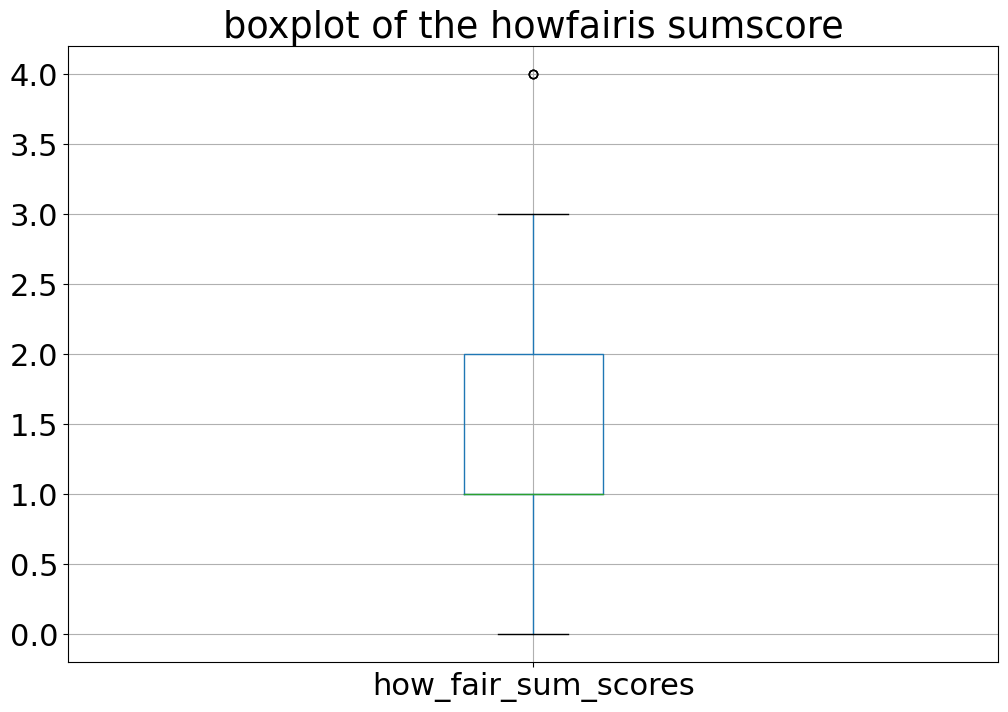

In [36]:
how_fair_is['how_fair_sum_scores'] = how_fair_sum_scores
print("mean: {:.2f}".format(statistics.mean(how_fair_sum_scores)))
print("median: {}".format(statistics.median(how_fair_sum_scores)))
pd.DataFrame((statistics.mean(how_fair_sum_scores), statistics.median(how_fair_sum_scores)),["mean", "median"])
how_fair_is.boxplot(column = 'how_fair_sum_scores')
plt.title('boxplot of the howfairis sumscore')
plt.savefig(Path(fp_figs, f'howfairissum_boxplot_{subset}.png'), bbox_inches="tight")


In [37]:
# how_fair_is['how_fair_sum_scores'].value_counts().sort_index().plot.bar(title = 'Scores howfairis')
# plt.savefig(Path(fp_figs, f'howfairissum_histogram_{subset}.png'), bbox_inches="tight")


howfairis_result = how_fair_is['how_fair_sum_scores'].value_counts().sort_index()
print(howfairis_result)

ax = sns.barplot(howfairis_result.index, howfairis_result / howfairis_result.sum() * 100, palette='Blues_d')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_ylabel("Percentage")
ax.set_title("Score in howfairis tool (in %)")

0       1
1    1162
2     766
3      28
4       3
Name: how_fair_sum_scores, dtype: int64


TypeError: barplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

In [38]:
correlation_df = pd.DataFrame()
months_ago_most_recent_commit =[]
today = str(date.today())
split_today = today.split('-')
for date_item in repos['updated_at']:
    split_date = date_item.split('-')
    years_ago = int(split_today[0]) - int(split_date[0])
    months_ago = 12 * years_ago + (int(split_today[1]) - int(split_date[1]))
    months_ago_most_recent_commit.append(months_ago)
repos['months_ago_most_recent_commit'] = months_ago_most_recent_commit

NameError: name 'repos' is not defined

In [39]:
correlation_df['how_fair_sum_scores'] = how_fair_sum_scores
correlation_df['contributions']= contributors['contributions']
correlation_df['months_ago_most_recent_commit'] = repos['months_ago_most_recent_commit']

NameError: name 'contributors' is not defined

In [40]:
correlation_df.corr(method='pearson').round(decimals=2)

how_fair_sum_scores
how_fair_sum_scores                  1.0

In [41]:
unique_users = set(how_fair_is["owner"])
unique_users
howfairis_max_user = list()
howfairis_average = list()
for user in unique_users:
    repos_user = how_fair_is.loc[how_fair_is['owner'] == user]
    howfairis_max_user.append(max(repos_user["how_fair_sum_scores"]))
    num_repos = len(repos_user.index)
    average = sum(repos_user["how_fair_sum_scores"])/num_repos
    howfairis_average.append([average, num_repos])

In [42]:
plt.hist(howfairis_max_user, bins = range(1,7))
plt.xticks(range(1,6))
plt.ylabel('Count')
plt.xlabel('Howfairis score')
plt.title("Max howfairis score per user aggregated, " + str(len(unique_users)) + " users")
plt.savefig(Path(fp_figs, f'howfairis_stacked_max{subset}.png'), bbox_inches="tight")

NameError: name 'fp_figs' is not defined

In [43]:
plt.scatter(*zip(*howfairis_average))
plt.ylabel('Number of repositories')
plt.xlabel('Average howfairis score')
plt.title("Average howfairis score per user, " + str(len(unique_users)) + " users")
plt.savefig(Path(fp_figs, f'howfairis_scatter_repos_avg{subset}.png'), bbox_inches="tight")

NameError: name 'fp_figs' is not defined

## Binary correlation plot between howfairis variables

A correlation table that shows the correlation between the howfairis measures.

In [44]:
correlation_how_fair_is = pd.DataFrame()

#correlation_how_fair_is['howfairis_repository'] = how_fair_is['howfairis_repository']
correlation_how_fair_is['howfairis_license'] = how_fair_is['howfairis_license']
correlation_how_fair_is['howfairis_registry'] = how_fair_is['howfairis_registry']
correlation_how_fair_is['howfairis_citation'] = how_fair_is['howfairis_citation']
correlation_how_fair_is['howfairis_checklist'] = how_fair_is['howfairis_checklist']



In [45]:
correlation_how_fair_is.corr(method='pearson').round(decimals=2) #howfairis_repository is all true, so has no variance

howfairis_license  howfairis_registry  \
howfairis_license                 1.00                0.09   
howfairis_registry                0.09                1.00   
howfairis_citation                0.11                0.15   
howfairis_checklist                NaN                 NaN   

                     howfairis_citation  howfairis_checklist  
howfairis_license                  0.11                  NaN  
howfairis_registry                 0.15                  NaN  
howfairis_citation                 1.00                  NaN  
howfairis_checklist                 NaN                  NaN

## Programming language and Howfairis

Different programming languages need different licences. For some languages (e.g. python), these are more complex. How does this influence the HowFairis score?

In [46]:
index_how_fair_is = 0
language_how_fair_is_df = []
#get a list with the how-fair-is scores added to the language dataset
for index,row in languages.iterrows():
    if how_fair_is['html_url'][index_how_fair_is] != languages['html_url_repository'][index]:
        index_how_fair_is += 1 
    sum_score = how_fair_is['how_fair_sum_scores'][index_how_fair_is]
    language_how_fair_is_df.append(sum_score)
regression_data_how_fair_is_language = pd.DataFrame()
language_data_dummies = pd.get_dummies(languages['language'])  #one hot-encoding for language dataset
regression_data_how_fair_is_language['how_fair_is_sum'] = language_how_fair_is_df
languages['how_fair_sum_scores'] = regression_data_how_fair_is_language #add scores to language dataset

NameError: name 'languages' is not defined

In [47]:
train_size = int(len(languages) * 0.8) #training size is 2227, testing size is  557
regression_how_fair_is_language_train_X = language_data_dummies[:train_size]
regression_how_fair_is_language_train_y = regression_data_how_fair_is_language['how_fair_is_sum'][:train_size]
regression_how_fair_is_language_test_X = language_data_dummies[train_size:]
regression_how_fair_is_language_test_y = regression_data_how_fair_is_language['how_fair_is_sum'][train_size:]

NameError: name 'languages' is not defined

In [48]:
#train regression
regression_language_how_fair_is = LinearRegression()
regression_language_how_fair_is.fit(regression_how_fair_is_language_train_X, regression_how_fair_is_language_train_y)

# Make predictions using the testing set
language_how_fair_is_y_pred = regression_language_how_fair_is.predict(regression_how_fair_is_language_test_X)

# The coefficients
#print('Coefficients: \n', regression_language_how_fair_is.coef_)

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(regression_how_fair_is_language_test_y, language_how_fair_is_y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(regression_how_fair_is_language_test_y, language_how_fair_is_y_pred))


NameError: name 'regression_how_fair_is_language_train_X' is not defined

In [49]:
language_subset = language_data_dummies[['Python', 'Shell', 'R', 'JavaScript', 'HTML']] #top 5 languages


NameError: name 'language_data_dummies' is not defined

In [50]:
train_size = int(len(language_subset) * 0.8)
regression_how_fair_is_language_train_X = language_subset[:train_size]
regression_how_fair_is_language_train_y = regression_data_how_fair_is_language['how_fair_is_sum'][:train_size]
regression_how_fair_is_language_test_X = language_subset[train_size:]
regression_how_fair_is_language_test_y = regression_data_how_fair_is_language['how_fair_is_sum'][train_size:]

NameError: name 'language_subset' is not defined

In [51]:
#train regression
regression_language_how_fair_is = LinearRegression()
regression_language_how_fair_is.fit(regression_how_fair_is_language_train_X, regression_how_fair_is_language_train_y)

# Make predictions using the testing set
language_how_fair_is_y_pred = regression_language_how_fair_is.predict(regression_how_fair_is_language_test_X)

# The coefficients
print('Coefficients: \n', regression_language_how_fair_is.coef_)

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(regression_how_fair_is_language_test_y, language_how_fair_is_y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(regression_how_fair_is_language_test_y, language_how_fair_is_y_pred))


NameError: name 'regression_how_fair_is_language_train_X' is not defined

A simple regression for predicting the how fair is score from  all or a subset of languages does not seem to yield any results 

## Examples of high howfairis scores 

In this section, some links to the pages that have a high howfairis score are shown. 

In [52]:
how_fair_is_high_scores = how_fair_is[how_fair_is['how_fair_sum_scores'] > 3].sort_values('how_fair_sum_scores', ascending=False)

how_fair_is_high_scores[['html_url', 'how_fair_sum_scores']]

html_url  how_fair_sum_scores
1330                     https://github.com/mmrabe/hypr                    4
1419              https://github.com/PIK-LPJmL/lpjmlkit                    4
1733  https://github.com/University-of-Potsdam-MM/cf...                    4

## Re-use of other projects and articles

Are there competitors?
How do they relate to each other?

## Installation statistics

In [53]:
installations[installations["repository_name"] != "pcalg"].sort_values("last_month", ascending=False).reset_index(drop=True).drop("date", axis=1)

NameError: name 'installations' is not defined